# Hospital Doctor Shifts Allocation (Part 1) - Linear Programming

We have 5 doctors as a workforce and they need to work in a hospital’s 3 shift-system and a 2-shift-system on weekends and holidays respectively. The main goal of this solution is to develop an optimization engine for shift allocation so that every doctor shall work an near equally allocated sum of A) morning shifts, B) evening shifts, C) nights shifts and D) weekend day shifts for the next week.

There are several kind of shifts: Week days have three 8-hr shifts (morning, evening, night) and weekend has two 12-hr shifts (day, night). Each doctor can only work 1 shift per day and each doctor needs at least 8h resting time between two shifts. Each doctor prefers to work on a consecutive set of seven shifts of the same kind, i.e. he/she can work from Monday to Sunday in morning shift and then he may switch to evening shift. This is also true for night shifts.

We will look at ways of mathematically modelling this assignment problem subject to:

1. hard-rules such as each doctor can only work 1 shift per day and each doctor needs at least 8h resting time
2. soft-rules such as preferring a certain shift pattern (i.e. consecutive set of seven shifts of the same kind)
3. objectives such as minimising the number of working hours per week (40 hours is the maximum) near equal total working hours for every doctor

 - reference: https://github.com/ilkarman/MILP-Airport-Assignment

## Part 1 - Hard-rules

In [105]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pulp
from pulp import *
import pickle
import grep
from pandas import DataFrame


In [106]:
# Create sample data
turns = pd.DataFrame({
    'turn_no':[1,2,3,4,5],
    'shift_capacity':[5,5,5,5,5]
    }, columns=['turn_no', 'shift_capacity'])

hospital = pd.DataFrame({
    'dayofweek':['Mon','Mon','Mon','Tue','Tue','Tue','Wed','Wed','Wed','Thu','Thu','Thu','Fri','Fri','Fri','Sat','Sat','Sun','Sun'],
    'shiftnum':['Mon1','Mon2','Mon3','Tue1','Tue2','Tue3','Wed1','Wed2','Wed3','Thu1','Thu2','Thu3','Fri1','Fri2','Fri3','Sat1','Sat2','Sun1','Sun2'],
    'max_size':[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
    }, columns = ['dayofweek', 'shiftnum', 'max_size'])

In [107]:
hospital

,dayofweek,shiftnum,max_size
0,Mon,Mon1,1
1,Mon,Mon2,1
2,Mon,Mon3,1
3,Tue,Tue1,1
4,Tue,Tue2,1
5,Tue,Tue3,1
6,Wed,Wed1,1
7,Wed,Wed2,1
8,Wed,Wed3,1
9,Thu,Thu1,1


In [108]:
turns

,turn_no,shift_capacity
0,1,5
1,2,5
2,3,5
3,4,5
4,5,5


In [109]:
turn_list = turns.turn_no.get_values()
print("Turns to allocate: ", turn_list)

shift_list = hospital.shiftnum.get_values()
print("Available shirts: ", gate_list)

dow_list = list(set(hospital.dayofweek.get_values()))
print("Possible Days of Week: ", dow_list)

Turns to allocate:  [1 2 3 4 5]
Available shirts:  ['Mon1' 'Mon2' 'Mon3' 'Tue1' 'Tue2' 'Tue3' 'Wed1' 'Wed2' 'Wed3' 'Thu1'
 'Thu2' 'Thu3' 'Fri1' 'Fri2' 'Fri3' 'Sat1' 'Sat2' 'Sun1' 'Sun2']
Possible Days of Week:  ['Tue', 'Wed', 'Mon', 'Fri', 'Sat', 'Sun', 'Thu']


## Model A - Simple Static Model

In [110]:
# 0. Initialise model
prob = LpProblem("Hospital Shift Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

print(prob)

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in shift_list:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list) <= 5

# ii. Gates cannot have more than one turn/plane
for g in shift_list:
    prob += lpSum(x[t, g] for t in turn_list) == 1
    
# Formula
print(prob)

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

i = 0
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

listalloc = []
shift_list_new = []

var = prob.variables()
del var[0]

for v in var:
        listalloc += [v.varValue]
        gatestr = str(v).split("_g", 2)[1]
        if gatestr not in shift_list_new:
            shift_list_new.append(gatestr) 
                

Hospital Shift Allocation:
MINIMIZE
0
VARIABLES

Hospital Shift Allocation:
MINIMIZE
0
SUBJECT TO
_C1: t1_gFri1 + t1_gFri2 + t1_gFri3 + t1_gMon1 + t1_gMon2 + t1_gMon3
 + t1_gSat1 + t1_gSat2 + t1_gSun1 + t1_gSun2 + t1_gThu1 + t1_gThu2 + t1_gThu3
 + t1_gTue1 + t1_gTue2 + t1_gTue3 + t1_gWed1 + t1_gWed2 + t1_gWed3 <= 5

_C2: t2_gFri1 + t2_gFri2 + t2_gFri3 + t2_gMon1 + t2_gMon2 + t2_gMon3
 + t2_gSat1 + t2_gSat2 + t2_gSun1 + t2_gSun2 + t2_gThu1 + t2_gThu2 + t2_gThu3
 + t2_gTue1 + t2_gTue2 + t2_gTue3 + t2_gWed1 + t2_gWed2 + t2_gWed3 <= 5

_C3: t3_gFri1 + t3_gFri2 + t3_gFri3 + t3_gMon1 + t3_gMon2 + t3_gMon3
 + t3_gSat1 + t3_gSat2 + t3_gSun1 + t3_gSun2 + t3_gThu1 + t3_gThu2 + t3_gThu3
 + t3_gTue1 + t3_gTue2 + t3_gTue3 + t3_gWed1 + t3_gWed2 + t3_gWed3 <= 5

_C4: t4_gFri1 + t4_gFri2 + t4_gFri3 + t4_gMon1 + t4_gMon2 + t4_gMon3
 + t4_gSat1 + t4_gSat2 + t4_gSun1 + t4_gSun2 + t4_gThu1 + t4_gThu2 + t4_gThu3
 + t4_gTue1 + t4_gTue2 + t4_gTue3 + t4_gWed1 + t4_gWed2 + t4_gWed3 <= 5

_C5: t5_gFri1 + t5_gFr

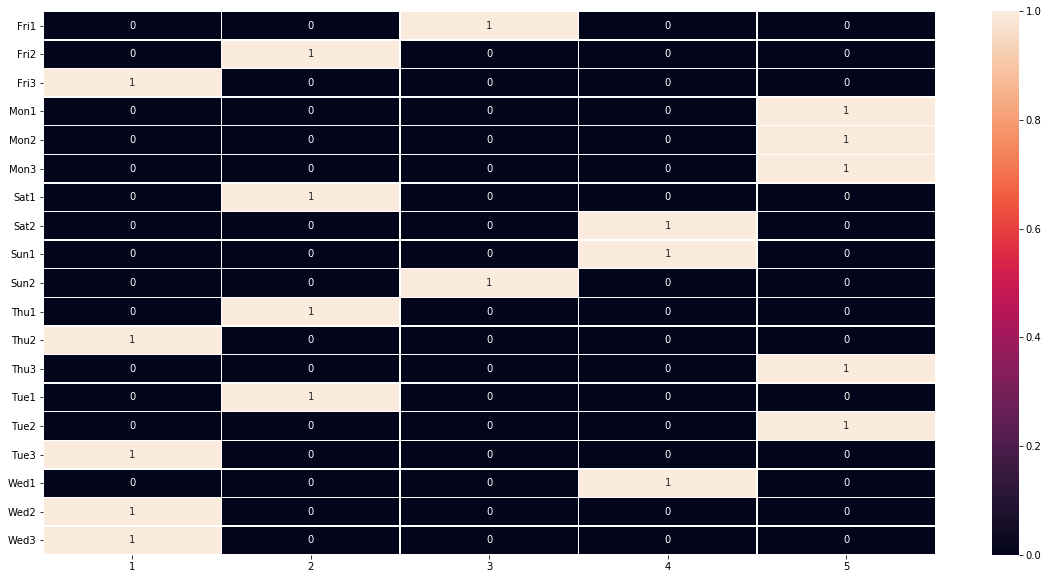

In [111]:
Index= shift_list_new
Cols = turn_list

alloc = np.reshape(listalloc, (5, 19)).T

df = DataFrame(alloc, index=Index, columns=Cols)

fig, ax = plt.subplots(figsize=(20,10))        
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(df, annot=True, linewidths=.5, ax=ax)

## Model B - Adding an Implicit Constraint

In [114]:
# 0. Initialise model
prob = LpProblem("Hospital Shift Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

print(prob)

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    for g in gate_list:
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list) <= 5

# ii. Gates cannot have more than one turn/plane
for g in shift_list:
    prob += lpSum(x[t, g] for t in turn_list) == 1
    
# iii. Each doctor can only be assigned to ONE shift per work day
for t in turn_list:
    for g in dow_list:
        new_shift_list = list(filter(lambda x:g in x, shift_list))
        prob += lpSum(x[t, h] for h in new_shift_list) <= 1


# Formula
print(prob)

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

i = 0
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))

listalloc = []
gate_list_new = []

var = prob.variables()
del var[0]

print(var)

shift_list_new =[]
for v in var:
        listalloc += [v.varValue]
        gatestr = str(v).split("_g", 2)[1]
        if gatestr not in shift_list_new:
            shift_list_new.append(gatestr) 


Hospital Shift Allocation:
MINIMIZE
0
VARIABLES

Hospital Shift Allocation:
MINIMIZE
0
SUBJECT TO
_C1: t1_gFri1 + t1_gFri2 + t1_gFri3 + t1_gMon1 + t1_gMon2 + t1_gMon3
 + t1_gSat1 + t1_gSat2 + t1_gSun1 + t1_gSun2 + t1_gThu1 + t1_gThu2 + t1_gThu3
 + t1_gTue1 + t1_gTue2 + t1_gTue3 + t1_gWed1 + t1_gWed2 + t1_gWed3 <= 5

_C2: t2_gFri1 + t2_gFri2 + t2_gFri3 + t2_gMon1 + t2_gMon2 + t2_gMon3
 + t2_gSat1 + t2_gSat2 + t2_gSun1 + t2_gSun2 + t2_gThu1 + t2_gThu2 + t2_gThu3
 + t2_gTue1 + t2_gTue2 + t2_gTue3 + t2_gWed1 + t2_gWed2 + t2_gWed3 <= 5

_C3: t3_gFri1 + t3_gFri2 + t3_gFri3 + t3_gMon1 + t3_gMon2 + t3_gMon3
 + t3_gSat1 + t3_gSat2 + t3_gSun1 + t3_gSun2 + t3_gThu1 + t3_gThu2 + t3_gThu3
 + t3_gTue1 + t3_gTue2 + t3_gTue3 + t3_gWed1 + t3_gWed2 + t3_gWed3 <= 5

_C4: t4_gFri1 + t4_gFri2 + t4_gFri3 + t4_gMon1 + t4_gMon2 + t4_gMon3
 + t4_gSat1 + t4_gSat2 + t4_gSun1 + t4_gSun2 + t4_gThu1 + t4_gThu2 + t4_gThu3
 + t4_gTue1 + t4_gTue2 + t4_gTue3 + t4_gWed1 + t4_gWed2 + t4_gWed3 <= 5

_C5: t5_gFri1 + t5_gFr

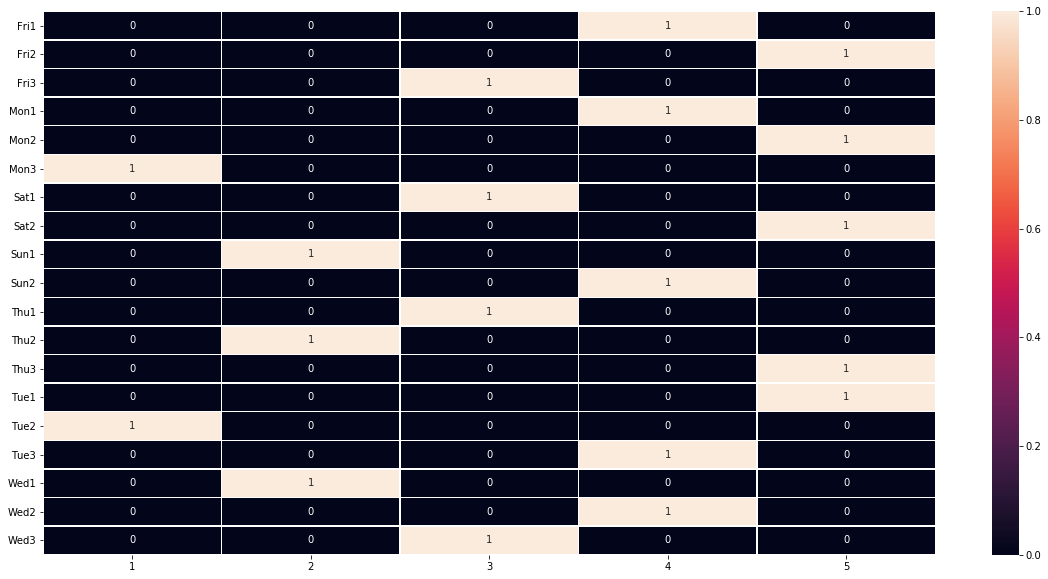

In [115]:
Index= shift_list_new
Cols = turn_list
alloc = np.reshape(listalloc, (5, 19)).T

df = DataFrame(alloc, index=Index, columns=Cols)

fig, ax = plt.subplots(figsize=(20,10))        
#sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(df, annot=True, linewidths=.5, ax=ax)